Dijikstra Algorithm

In [2]:
import pandas as pd
from zipfile import ZipFile
import numpy as np
import random
import datetime as dt
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from heapq import heapify, heappop, heappush

In [ ]:
with ZipFile("Airline_dataset.csv.zip","r") as zip:
    zip.extractall()

In [ ]:
with ZipFile("airport_coords.zip","r") as z:
    z.extractall()

The dataset was acquired from https://www.transtats.bts.gov/DL SelectFields.asp?Table ID=236 and https://data.world/dot/airline-on-time-performance-statistics

In [326]:
data = pd.read_csv("Airline_dataset.csv",index_col=0)
df = data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1204825 entries, 0 to 1226367
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   FL_DATE         1204825 non-null  object 
 1   AIRLINE_ID      1204825 non-null  float64
 2   TAIL_NUM        1204825 non-null  object 
 3   FLIGHT_NUM      1204825 non-null  float64
 4   ORIGIN_SEQ_ID   1204825 non-null  float64
 5   ORIGIN_AIRPORT  1204825 non-null  object 
 6   DEST_SEQ_ID     1204825 non-null  float64
 7   DEST_AIRPORT    1204825 non-null  object 
 8   DEP_TIME        1204825 non-null  float64
 9   DEP_DELAY       1204247 non-null  float64
 10  ARR_TIME        1204825 non-null  float64
 11  ARR_DELAY       1201443 non-null  float64
 12  WEATHER_DELAY   1204825 non-null  float64
dtypes: float64(9), object(4)
memory usage: 128.7+ MB


In [327]:
data.shape

(1204825, 13)

In [328]:
data.head()

,FL_DATE,AIRLINE_ID,TAIL_NUM,FLIGHT_NUM,ORIGIN_SEQ_ID,ORIGIN_AIRPORT,DEST_SEQ_ID,DEST_AIRPORT,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,WEATHER_DELAY
0,8/1/18,19805.0,N956AN,1587.0,1247805.0,JFK,1410702.0,PHX,1649.0,9.0,2006.0,44.0,0.000000
1,8/1/18,19805.0,N973AN,1588.0,1410702.0,PHX,1161802.0,EWR,1541.0,29.0,2350.0,53.0,0.000000
2,8/1/18,19805.0,N9006,1590.0,1104205.0,CLE,1129806.0,DFW,741.0,-3.0,938.0,-2.0,4.030195
3,8/1/18,19805.0,N870NN,1591.0,1484306.0,SJU,1129806.0,DFW,944.0,44.0,1347.0,43.0,0.000000
4,8/1/18,19805.0,N9023N,1593.0,1042302.0,AUS,1330303.0,MIA,556.0,-4.0,951.0,-2.0,4.030195


Typecasting all features for better data manipulation and model building

In [329]:
data["FL_DATE"] = pd.to_datetime(data["FL_DATE"],format = "%m/%d/%y")
data.head()

,FL_DATE,AIRLINE_ID,TAIL_NUM,FLIGHT_NUM,ORIGIN_SEQ_ID,ORIGIN_AIRPORT,DEST_SEQ_ID,DEST_AIRPORT,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,WEATHER_DELAY
0,2018-08-01,19805.0,N956AN,1587.0,1247805.0,JFK,1410702.0,PHX,1649.0,9.0,2006.0,44.0,0.000000
1,2018-08-01,19805.0,N973AN,1588.0,1410702.0,PHX,1161802.0,EWR,1541.0,29.0,2350.0,53.0,0.000000
2,2018-08-01,19805.0,N9006,1590.0,1104205.0,CLE,1129806.0,DFW,741.0,-3.0,938.0,-2.0,4.030195
3,2018-08-01,19805.0,N870NN,1591.0,1484306.0,SJU,1129806.0,DFW,944.0,44.0,1347.0,43.0,0.000000
4,2018-08-01,19805.0,N9023N,1593.0,1042302.0,AUS,1330303.0,MIA,556.0,-4.0,951.0,-2.0,4.030195


In [330]:
#Utilizing only 1 month's data for the analysis

data = data[data["FL_DATE"].dt.date < dt.date(2019,1,1)]

In [331]:
# Converting into favorable datatype
data["DEP_TIME"] = data["DEP_TIME"].astype(int).astype(str)
data["ARR_TIME"] = data["ARR_TIME"].astype(int).astype(str)

In [332]:
# Time Feature Format in HHMM
data["DEP_TIME"] = pd.to_datetime(data["DEP_TIME"].str.zfill(4),format = "%H%M",errors = "coerce")
data["ARR_TIME"] = pd.to_datetime(data["ARR_TIME"].str.zfill(4),format = "%H%M",errors = "coerce")

In [333]:
data["DEP_TIME"].isna().sum()

np.int64(81)

Treating Null values

Confirming if the null values in our columns represent midnight

In [334]:
null_row = data[data["DEP_TIME"].isnull()].index
print("Null values input for departure time field =>",df.loc[null_row, "DEP_TIME"].unique())
null_row = data[data["ARR_TIME"].isnull()].index
print("Null values input for departure time field =>",df.loc[null_row, "ARR_TIME"].unique())


Null values input for departure time field => [2400.]
Null values input for departure time field => [2400.]


In [335]:
data.dtypes

FL_DATE           datetime64[ns]
AIRLINE_ID               float64
TAIL_NUM                  object
FLIGHT_NUM               float64
ORIGIN_SEQ_ID            float64
ORIGIN_AIRPORT            object
DEST_SEQ_ID              float64
DEST_AIRPORT              object
DEP_TIME          datetime64[ns]
DEP_DELAY                float64
ARR_TIME          datetime64[ns]
ARR_DELAY                float64
WEATHER_DELAY            float64
dtype: object

In [336]:
data["DEP_TIME"]=data["DEP_TIME"].fillna(pd.to_datetime("0000",format = "%H%M"))
data["ARR_TIME"] =data["ARR_TIME"].fillna(pd.to_datetime("0000",format = "%H%M"))
#To prevent all time from being represented as from year 1900 which is the default, we convert it too dt.time for readability
data["DEP_TIME"] = data["DEP_TIME"].dt.time
data["ARR_TIME"] = data["ARR_TIME"].dt.time
data.head()

,FL_DATE,AIRLINE_ID,TAIL_NUM,FLIGHT_NUM,ORIGIN_SEQ_ID,ORIGIN_AIRPORT,DEST_SEQ_ID,DEST_AIRPORT,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,WEATHER_DELAY
0,2018-08-01,19805.0,N956AN,1587.0,1247805.0,JFK,1410702.0,PHX,16:49:00,9.0,20:06:00,44.0,0.000000
1,2018-08-01,19805.0,N973AN,1588.0,1410702.0,PHX,1161802.0,EWR,15:41:00,29.0,23:50:00,53.0,0.000000
2,2018-08-01,19805.0,N9006,1590.0,1104205.0,CLE,1129806.0,DFW,07:41:00,-3.0,09:38:00,-2.0,4.030195
3,2018-08-01,19805.0,N870NN,1591.0,1484306.0,SJU,1129806.0,DFW,09:44:00,44.0,13:47:00,43.0,0.000000
4,2018-08-01,19805.0,N9023N,1593.0,1042302.0,AUS,1330303.0,MIA,05:56:00,-4.0,09:51:00,-2.0,4.030195


In [337]:
# Time Features in minutes
data["DEP_DELAY"] = data["DEP_DELAY"].fillna(0)
data["ARR_DELAY"] = data["ARR_DELAY"].fillna(0)
data["WEATHER_DELAY"] = data["WEATHER_DELAY"].fillna(0) 

data["DEP_DELAY"]  = data["DEP_DELAY"].astype(int)
data["ARR_DELAY"]  = data["ARR_DELAY"].astype(int)
data["WEATHER_DELAY"]  = data["WEATHER_DELAY"].astype(int)

In [338]:
data["DEP_DELAY"]  =pd.to_timedelta(data["DEP_DELAY"],unit = "m")
data["ARR_DELAY"] = pd.to_timedelta(data["ARR_DELAY"],unit = "m")
data["WEATHER_DELAY"] = pd.to_timedelta(data["WEATHER_DELAY"],unit = "m")

In [339]:
data["AIRLINE_ID"] = data["AIRLINE_ID"].astype(int)
data["FLIGHT_NUM"] = data["FLIGHT_NUM"].astype(int)

In [340]:
data.drop(columns = ["DEST_SEQ_ID","ORIGIN_SEQ_ID"], inplace =True)

Segmenting using Arrival time to optimize time for total travel time optimization. 

Each day can be segmented into 6 parts:

Early morning (4:00 - 7:59)

Morning (8:00-11:59)

Afternoon (12:00 - 15:59)

Evening (16:00 - 19:59)

Night (20:00 - 23:59)

Late Night (00:00 - 3:59)

In [341]:
time_buckets = pd.date_range(start="00:00",end = "23:59", freq = "4h").time
label = ("Late Night","Early_morning","Morning","Afternoon","Evening","Night")

def segmentation(arrival_time):
    for i in range(len(time_buckets)-1):
        if time_buckets[i] <= arrival_time < time_buckets[i+1]:
            return label[i]
    return label[-1]

In [342]:
data["day_segment"] = data["ARR_TIME"].apply(segmentation)

In [343]:
data.head()

,FL_DATE,AIRLINE_ID,TAIL_NUM,FLIGHT_NUM,ORIGIN_AIRPORT,DEST_AIRPORT,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,WEATHER_DELAY,day_segment
0,2018-08-01,19805,N956AN,1587,JFK,PHX,16:49:00,0 days 00:09:00,20:06:00,0 days 00:44:00,0 days 00:00:00,Night
1,2018-08-01,19805,N973AN,1588,PHX,EWR,15:41:00,0 days 00:29:00,23:50:00,0 days 00:53:00,0 days 00:00:00,Night
2,2018-08-01,19805,N9006,1590,CLE,DFW,07:41:00,-1 days +23:57:00,09:38:00,-1 days +23:58:00,0 days 00:04:00,Morning
3,2018-08-01,19805,N870NN,1591,SJU,DFW,09:44:00,0 days 00:44:00,13:47:00,0 days 00:43:00,0 days 00:00:00,Afternoon
4,2018-08-01,19805,N9023N,1593,AUS,MIA,05:56:00,-1 days +23:56:00,09:51:00,-1 days +23:58:00,0 days 00:04:00,Morning


Computing airtime (HH:MM) which can be used as weights of our edges in network graph.

In [344]:
def compute_airtime(flight_date, dep_time, dep_delay, arr_time, arr_delay, weather_delay):
    # Departure time is adjusted to account for the delay
    adj_dep = dt.datetime.combine(flight_date, dep_time) + dep_delay
    # Arrival time is adjusted to accoutn for the weather and arrival delay
    adj_arr = dt.datetime.combine(flight_date,arr_time) + arr_delay + weather_delay

    #Midnight Crossing cases
    if adj_arr < adj_dep:
        org_adj_arr = adj_arr
        adj_arr += dt.timedelta(days =1)
    
    diff = adj_arr - adj_dep
    
    # Catching exceptions 
    if diff < dt.timedelta(seconds = 0):
        print("org adj_Arrival =",org_adj_arr)
        print("corrected adj_Arrival =",adj_arr)
        print("Departre time =", adj_dep)
        print("Negative airtime",flight_date,"#",dep_time,"#",arr_time)
        return None

    min,sec = divmod(diff.total_seconds(),60)
    # hr,sec = divmod(diff.total_seconds(),3600)
    # min = sec//60
    return int(min)


In [345]:
data["airtime"] = data.apply(lambda row : compute_airtime(row["FL_DATE"],row["DEP_TIME"], row["DEP_DELAY"], row["ARR_TIME"], \
                                                        row["ARR_DELAY"], row["WEATHER_DELAY"]), axis =1)

org adj_Arrival = 2018-08-03 00:45:00
corrected adj_Arrival = 2018-08-04 00:45:00
Departre time = 2018-08-04 00:49:00
Negative airtime 2018-08-03 00:00:00 # 21:19:00 # 00:41:00
org adj_Arrival = 2018-08-16 02:33:00
corrected adj_Arrival = 2018-08-17 02:33:00
Departre time = 2018-08-17 03:19:00
Negative airtime 2018-08-16 00:00:00 # 22:41:00 # 02:29:00
org adj_Arrival = 2018-08-17 02:59:00
corrected adj_Arrival = 2018-08-18 02:59:00
Departre time = 2018-08-18 05:04:00
Negative airtime 2018-08-17 00:00:00 # 22:42:00 # 02:55:00
org adj_Arrival = 2018-08-20 00:22:00
corrected adj_Arrival = 2018-08-21 00:22:00
Departre time = 2018-08-21 01:33:00
Negative airtime 2018-08-20 00:00:00 # 20:22:00 # 00:18:00


The output of the debugging shows that there are 9 cases of data error where the arrival of flight is a day earlier than the departure. These cases are isolated and removed from the dataset. 

In [346]:
print("The erroneous records are =>", data.isnull().sum().sum())
data.dropna(inplace = True,ignore_index=True)
data.shape

The erroneous records are => 4


(686880, 13)

In [347]:
data["airtime"] = data["airtime"].astype(int)
data.dtypes

FL_DATE            datetime64[ns]
AIRLINE_ID                  int64
TAIL_NUM                   object
FLIGHT_NUM                  int64
ORIGIN_AIRPORT             object
DEST_AIRPORT               object
DEP_TIME                   object
DEP_DELAY         timedelta64[ns]
ARR_TIME                   object
ARR_DELAY         timedelta64[ns]
WEATHER_DELAY     timedelta64[ns]
day_segment                object
airtime                     int64
dtype: object

### Accounting for departure and arrival delays causes null value in airtime. This might be due to erroneous delay entries.
### Shortest domestic commercial route for US airlines is San Francisco to Sata rosa route with 15min air time operated by Alaska airlines. So discarding records with less than the minimum

In [371]:
bad_delay_rows = data[data["airtime"] < 15].index
data.drop(index = bad_delay_rows,inplace = True)

In [375]:
data.shape

(680456, 13)

In [378]:
data.to_pickle("cleaned.pkl")

In [3]:
data = pd.read_pickle("cleaned.pkl")

In [3]:
data.shape

(680456, 13)

In [5]:
data[(data["ORIGIN_AIRPORT"]=="ATL") & (data["DEST_AIRPORT"]=="YAK")]

,FL_DATE,AIRLINE_ID,TAIL_NUM,FLIGHT_NUM,ORIGIN_AIRPORT,DEST_AIRPORT,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,WEATHER_DELAY,day_segment,airtime


In [4]:
data.head()

,FL_DATE,AIRLINE_ID,TAIL_NUM,FLIGHT_NUM,ORIGIN_AIRPORT,DEST_AIRPORT,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,WEATHER_DELAY,day_segment,airtime
0,2018-08-01,19805,N956AN,1587,JFK,PHX,16:49:00,0 days 00:09:00,20:06:00,0 days 00:44:00,0 days 00:00:00,Night,232
1,2018-08-01,19805,N973AN,1588,PHX,EWR,15:41:00,0 days 00:29:00,23:50:00,0 days 00:53:00,0 days 00:00:00,Night,513
2,2018-08-01,19805,N9006,1590,CLE,DFW,07:41:00,-1 days +23:57:00,09:38:00,-1 days +23:58:00,0 days 00:04:00,Morning,122
3,2018-08-01,19805,N870NN,1591,SJU,DFW,09:44:00,0 days 00:44:00,13:47:00,0 days 00:43:00,0 days 00:00:00,Afternoon,242
4,2018-08-01,19805,N9023N,1593,AUS,MIA,05:56:00,-1 days +23:56:00,09:51:00,-1 days +23:58:00,0 days 00:04:00,Morning,241


In [4]:
data.dtypes

FL_DATE            datetime64[ns]
AIRLINE_ID                  int64
TAIL_NUM                   object
FLIGHT_NUM                  int64
ORIGIN_AIRPORT             object
DEST_AIRPORT               object
DEP_TIME                   object
DEP_DELAY         timedelta64[ns]
ARR_TIME                   object
ARR_DELAY         timedelta64[ns]
WEATHER_DELAY     timedelta64[ns]
day_segment                object
airtime                     int64
dtype: object

In [5]:
print("Number of unique values for each columns are:")
for i in data.columns:
    print(i,"=>",data[i].nunique())

Number of unique values for each columns are:
FL_DATE => 31
AIRLINE_ID => 26
TAIL_NUM => 5757
FLIGHT_NUM => 6954
ORIGIN_AIRPORT => 365
DEST_AIRPORT => 365
DEP_TIME => 1430
DEP_DELAY => 1031
ARR_TIME => 1440
ARR_DELAY => 1074
WEATHER_DELAY => 443
day_segment => 6
airtime => 982


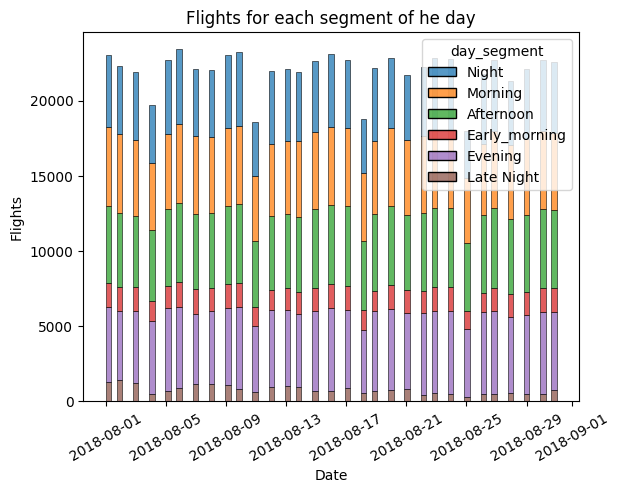

In [6]:
sns.histplot(data = data, x = "FL_DATE",hue = "day_segment", multiple = "stack")
plt.ylabel("Flights")
plt.xlabel("Date")
plt.title("Flights for each segment of he day")
plt.xticks(rotation =30)
plt.show()

The Above plot shows that late night and early morning have the least number of flights each day. That is from 00:00 till 08:00.

Text(-12.555555555555555, 0.5, 'Flights')

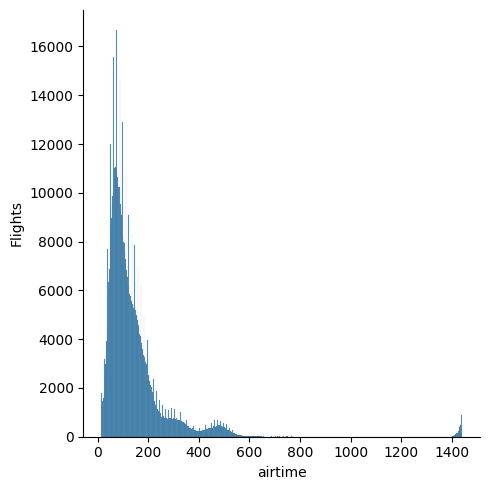

In [7]:
sns.displot(data["airtime"],kind = "hist")
plt.ylabel("Flights")

Using Djikstra on morning rush flights.

In [6]:
daytime = data[data["day_segment"] == "Morning"]

busiest_origin = pd.DataFrame(np.unique(daytime["ORIGIN_AIRPORT"],return_counts=True),index = ["Airport","routes"]).transpose()
busiest_origin = busiest_origin.sort_values(by="routes",ascending = False).reset_index(drop = True)
busiest_origin[:5]


,Airport,routes
0,ATL,7869
1,ORD,7566
2,DFW,5118
3,CLT,4636
4,DTW,3966


If a flight has a layover in between the origin and destination, its flight number changes but tail number remains the same. Using this we can form a graph with edges and nodes. Flight duration can be used as weight.

Scenario 1:

Direct Flights

Primary Node = ATL airport

destination Node = All other airports

Weights = (Arrival time + arrival delay + weather delay) -(departure time + departure Delay)

In [9]:
primary = busiest_origin.loc[0,"Airport"]
primary

'ATL'

In [10]:
data.head()

,FL_DATE,AIRLINE_ID,TAIL_NUM,FLIGHT_NUM,ORIGIN_AIRPORT,DEST_AIRPORT,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,WEATHER_DELAY,day_segment,airtime
0,2018-08-01,19805,N956AN,1587,JFK,PHX,16:49:00,0 days 00:09:00,20:06:00,0 days 00:44:00,0 days 00:00:00,Night,232
1,2018-08-01,19805,N973AN,1588,PHX,EWR,15:41:00,0 days 00:29:00,23:50:00,0 days 00:53:00,0 days 00:00:00,Night,513
2,2018-08-01,19805,N9006,1590,CLE,DFW,07:41:00,-1 days +23:57:00,09:38:00,-1 days +23:58:00,0 days 00:04:00,Morning,122
3,2018-08-01,19805,N870NN,1591,SJU,DFW,09:44:00,0 days 00:44:00,13:47:00,0 days 00:43:00,0 days 00:00:00,Afternoon,242
4,2018-08-01,19805,N9023N,1593,AUS,MIA,05:56:00,-1 days +23:56:00,09:51:00,-1 days +23:58:00,0 days 00:04:00,Morning,241


In [7]:
#Finding Unique routes in the dataset

## Grouping frequency can be done for as small as first hour of the day or 2nd hour of the day to improve accuracy

unique_routes_df = daytime.groupby(["ORIGIN_AIRPORT", "DEST_AIRPORT"])["airtime"].mean().reset_index()
unique_routes_df.head()

,ORIGIN_AIRPORT,DEST_AIRPORT,airtime
0,ABE,ATL,119.269231
1,ABE,CLT,112.565217
2,ABE,DTW,79.000000
3,ABE,ORD,44.000000
4,ABE,PHL,37.150000


In [14]:
unique_routes = set((row["ORIGIN_AIRPORT"],row["DEST_AIRPORT"],row["airtime"]) for _,row in unique_routes_df.iterrows())
len(unique_routes)

4237

In [15]:
coords = pd.read_csv("T_MASTER_CORD.csv")
coords.head()

,AIRPORT,DISPLAY_AIRPORT_NAME,AIRPORT_STATE_FIPS,CITY_MARKET_SEQ_ID,CITY_MARKET_ID,DISPLAY_CITY_MARKET_NAME_FULL,CITY_MARKET_WAC_SEQ_ID2,CITY_MARKET_WAC,LATITUDE,LONGITUDE
0,01A,Afognak Lake Airport,2.0,3000101,30001,"Afognak Lake, AK",101,1,58.109444,-152.906667
1,03A,Bear Creek Mining Strip,2.0,3000301,30003,"Granite Mountain, AK",101,1,65.548056,-161.071667
2,04A,Lik Mining Camp,2.0,3000401,30004,"Lik, AK",101,1,68.083333,-163.166667
3,05A,Little Squaw Airport,2.0,3000501,30005,"Little Squaw, AK",101,1,67.570000,-148.183889
4,06A,Kizhuyak Bay,2.0,3000601,30006,"Kizhuyak, AK",101,1,57.745278,-152.882778


In [16]:
#Checking for any missing airports in airport coordinate data

new_airports = []
for i in data["ORIGIN_AIRPORT"].unique():
    if i not in list(coords["AIRPORT"]):
        new_airports.append(i)
print(new_airports)

[]


In [17]:
data.head()

,FL_DATE,AIRLINE_ID,TAIL_NUM,FLIGHT_NUM,ORIGIN_AIRPORT,DEST_AIRPORT,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,WEATHER_DELAY,day_segment,airtime
0,2018-08-01,19805,N956AN,1587,JFK,PHX,16:49:00,0 days 00:09:00,20:06:00,0 days 00:44:00,0 days 00:00:00,Night,232
1,2018-08-01,19805,N973AN,1588,PHX,EWR,15:41:00,0 days 00:29:00,23:50:00,0 days 00:53:00,0 days 00:00:00,Night,513
2,2018-08-01,19805,N9006,1590,CLE,DFW,07:41:00,-1 days +23:57:00,09:38:00,-1 days +23:58:00,0 days 00:04:00,Morning,122
3,2018-08-01,19805,N870NN,1591,SJU,DFW,09:44:00,0 days 00:44:00,13:47:00,0 days 00:43:00,0 days 00:00:00,Afternoon,242
4,2018-08-01,19805,N9023N,1593,AUS,MIA,05:56:00,-1 days +23:56:00,09:51:00,-1 days +23:58:00,0 days 00:04:00,Morning,241


In [18]:
#Position dictionary with location of each airport

data_coords = coords.loc[coords["AIRPORT"].isin(list(data["ORIGIN_AIRPORT"].unique())),["AIRPORT","LATITUDE","LONGITUDE"]]
data_coords.drop_duplicates(subset = ["AIRPORT"],inplace = True, ignore_index = True)
positions = {row["AIRPORT"] : (row["LATITUDE"],-row["LONGITUDE"]) for _,row in data_coords.iterrows()}

In [19]:
# Airports present in routes of selected segment of the day
graph_nodes = []
for a,b,_ in unique_routes:
    graph_nodes.extend([a,b])
print(len(graph_nodes))
graph_nodes = list(set(graph_nodes))
print("The number of airports present in the current segment of day is: ",len(graph_nodes))

8474
The number of airports present in the current segment of day is:  344


In [20]:
graph_nodes[:5]

['FLO', 'PDX', 'GGG', 'BLI', 'AVP']

Air Traffic routes at Morning of the day


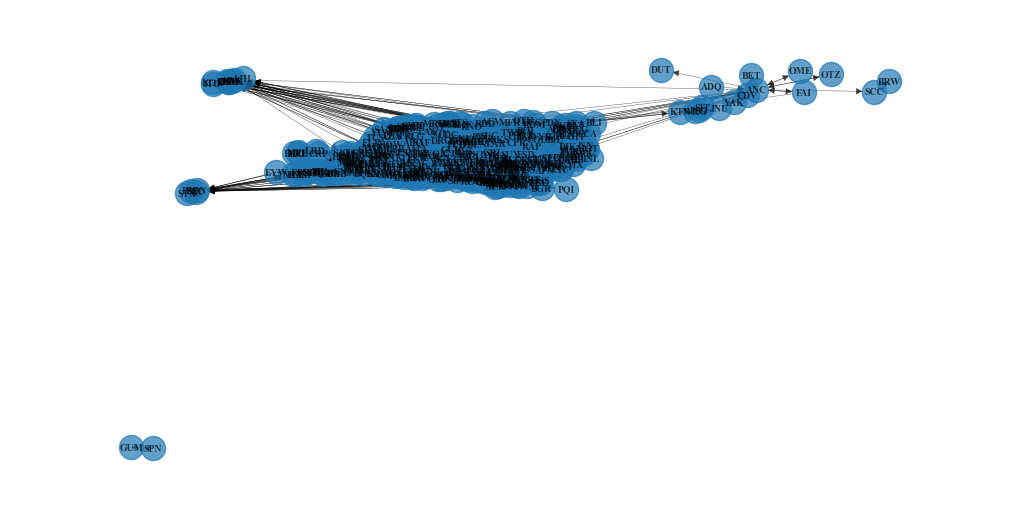

In [21]:
plt.figure(figsize=(10,5))
seed = 12

random.seed(seed) # To reproduce the same graph at every run, using random function here.
np.random.seed(seed) # NetworkX  utilizes both numpy and random package input to form a graph.

airports = nx.DiGraph() # Directed graph

airports.add_nodes_from(graph_nodes)

airports.add_weighted_edges_from(unique_routes)
print("Air Traffic routes at {} of the day".format(*daytime["day_segment"].unique()))
nx.draw(airports,pos = positions,with_labels = True, font_size = 7, font_weight ="bold", font_family = "Times New Roman",alpha = 0.7, width = 0.3)
plt.margins(0.1)
plt.show()

Implementation for undirected graph

In [22]:
class Dijikstra():
    def __init__(self,graph:dict = {}):
        self.graph = graph
     
    def shortest_duration(self, start: str, end: str):
        duration = {node : float("inf") for node in self.graph} # Duration dictionary keeps record of all distances from start
        duration[start] = 0
    
        queue = [(0,start)] #Priority queue helps maintain the order of shortest time
        heapify(queue)

        visited = set() #airport is added to this set after all its neighbors are explored.

        previous_node = {node : None for node in self.graph} #Helps in charting the shortest path

        while queue:
            current_duration,current_node = heappop(queue)

            if current_node in visited:
                continue
            visited.add(current_node) 

            for neighbor,travel_time in self.graph[current_node].items():
                new_duration = current_duration + travel_time["weight"]
                if new_duration < duration[neighbor]:
                    duration[neighbor] = new_duration
                    previous_node[neighbor] = current_node
                    heappush(queue,(new_duration,neighbor))

        #Path reconstruction
        shortest_path = []
        temp_node = end
        while temp_node is not None:
            shortest_path.append(temp_node)
            temp_node = previous_node[temp_node]
        shortest_path.reverse()
        return duration, shortest_path

In [23]:
find_shortest = Dijikstra(airports)

Function to get the shortest time path between them.

In [24]:
time, path = find_shortest.shortest_duration("JFK","PHX")
# print("shortest time in minutes to all airports from ATL is\n", time)
print("Shortest time from ATL to YAK during morning is {:.2f} min.".format(time["YAK"]))
print("The Shortest path from ATL to YAK airport is =>\n",path)

Shortest time from ATL to YAK during morning is 319.46 min.
The Shortest path from ATL to YAK airport is =>
 ['JFK', 'PHX']


Shortest route from ATL to YAK at Morning of the day
The route has a duration of 283.79 min.


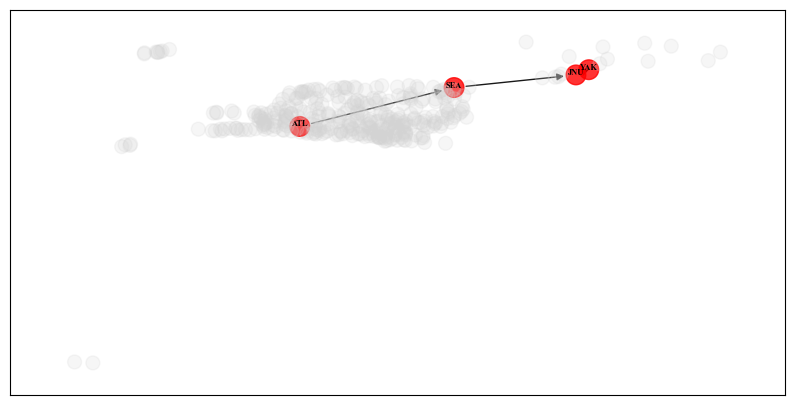

In [30]:
plt.figure(figsize=(10,5))
seed = 12

random.seed(seed) # To reproduce the same graph at every run, using random function here.
np.random.seed(seed) # NetworkX  utilizes both numpy and random package input to form a graph.

airports = nx.DiGraph() # Directed graph
airports.graph["Name"] = "Shortest route"

airports.add_nodes_from(graph_nodes)

colormap = []
node_sizes = []
visibility = {}
alphamap = []

for cnode in airports:
    if cnode in path:
        colormap.append('red')
        node_sizes.append(200)
        alphamap.append(0.8)
        visibility[cnode] = True
    else:
        colormap.append('lightgrey')
        visibility[cnode] = False
        node_sizes.append(100)
        alphamap.append(0.2)

airports.add_weighted_edges_from(unique_routes)
print("Shortest route from {} to {} at {} of the day".format(path[0],path[-1],*daytime["day_segment"].unique()))
print("The route has a duration of {:.2f} min.".format(time["YAK"]))
nx.draw_networkx_nodes(airports, pos = positions, node_color = colormap,node_size = node_sizes,alpha = alphamap)
nx.draw_networkx_edges(airports, pos = positions, alpha = 0.9,edgelist = list(zip(path,path[1:])))

for nod in graph_nodes:
    x,y = positions[nod]
    isvisible = visibility[nod]
    plt.text(x,y,nod,visible = isvisible ,fontsize = 6,fontfamily = "Times New Roman",fontweight = "bold",ha = "center")

plt.margins(0.1)
plt.show()